In [1]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # keep using v1 syntax 

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
non-resource variables are not supported in the long term


Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# **Don't do anything on this cell. This just create a folder on your google drive and they use to get real time data from server using Alpha vintage api.**

In [3]:
googlepath = "/content/drive/MyDrive/Sanjay Project /Code/28January2023/"
ALPHA_VANTAGE_KEY = "YFUTWYHB7TY1CD74" # This is a backup key.

# Setting the Training Amount
TRAINING_AMOUNT = 50000 # Number of steps to train the models
SAVE_STEPS_AMOUNT = 10000 # Frequency of which to save the models
PCT_CHANGE_AMOUNT = 5 # Percent Change Amount
HISTORICAL_DAYS_AMOUNT = 20 # Window to use for historical dayss
DAYS_AHEAD = 5 # How many days ahead to look

In [5]:
'''
Downloads stock data from alphavantage
'''
import pandas as pd 
import os
import time
import urllib
import json
import csv
import requests
import io
from pathlib import Path
import random

#Note should have companylist.csv in the directory with this file.

# Add stock_data folder
if not os.path.exists(f'{googlepath}stock_data'):
    os.makedirs(f'{googlepath}stock_data')

'''
Saves data to a file
'''
def save(googlepath, stock_csv, output_dir, filename):
    filepath = os.path.join(googlepath, output_dir, filename)
    try:
        df = stock_csv
        df.to_csv(filepath, index=False)
    except Exception as ex:
        print('Could not open file {} to write data'.format(filepath))
        print(ex)


def try_download(symbol):
    try:
        # Keep call frequency below threshold 
        time.sleep(15) # (5 per minute allowed for free service)
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(symbol, ALPHA_VANTAGE_KEY)
        df = pd.read_csv(url)
        df = df.drop(['split_coefficient', 'dividend_amount', 'adjusted_close'], axis=1)
        return df, True
    except Exception as ex:
        print(ex)
        return None, None


#Given a stock symbol (aka 'tsla') will download and save the data to the
#output dir as a csv 
def download_symbol(symbol, output_dir, retry_count=4):

    stock_csv, didPass = try_download(symbol)
    if didPass:
        save(googlepath, stock_csv, output_dir, '{}.csv'.format(symbol))
    else:
        print('Failed to download {}'.format(symbol))

df = pd.read_csv(f"{googlepath}companylist.csv")
for symbol in df.Symbol:
    my_file = Path(f"{googlepath}stock_data/{symbol}.csv")  # check if already downloaded
    if not my_file.exists():
        print('Downloading {}'.format(symbol))
        download_symbol(symbol, 'stock_data')
    else:
        print(f"Already downloaded {symbol}")

"['split_coefficient' 'dividend_amount' 'adjusted_close'] not found in axis"
Failed to download AGN
"['split_coefficient' 'dividend_amount' 'adjusted_close'] not found in axis"
Failed to download ADS
"['split_coefficient' 'dividend_amount' 'adjusted_close'] not found in axis"
Failed to download APC
"['split_coefficient' 'dividend_amount' 'adjusted_close'] not found in axis"
Failed to download ANTM


In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



## **Define GAN**

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 42
tf.set_random_seed(SEED)

class GAN():

    def sample_Z(self, batch_size, n):
        return np.random.uniform(-1., 1., size=(batch_size, n))

    def __init__(self, num_features, num_historical_days, generator_input_size=200, is_train=True):
        def get_batch_norm_with_global_normalization_vars(size):
            v = tf.Variable(tf.ones([size]), dtype=tf.float32)
            m = tf.Variable(tf.ones([size]), dtype=tf.float32)
            beta = tf.Variable(tf.ones([size]), dtype=tf.float32)
            gamma = tf.Variable(tf.ones([size]), dtype=tf.float32)
            return v, m, beta, gamma

        self.X = tf.compat.v1.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Z = tf.compat.v1.placeholder(tf.float32, shape=[None, generator_input_size])

        generator_output_size = num_features*num_historical_days
        with tf.variable_scope("generator"):
            W1 = tf.Variable(tf.truncated_normal([generator_input_size, generator_output_size*10]))
            b1 = tf.Variable(tf.truncated_normal([generator_output_size*10]))

            h1 = tf.nn.sigmoid(tf.matmul(self.Z, W1) + b1)

            W2 = tf.Variable(tf.truncated_normal([generator_output_size*10, generator_output_size*5]))
            b2 = tf.Variable(tf.truncated_normal([generator_output_size*5]))

            h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

            W3 = tf.Variable(tf.truncated_normal([generator_output_size*5, generator_output_size]))
            b3 = tf.Variable(tf.truncated_normal([generator_output_size]))

            g_log_prob = tf.matmul(h2, W3) + b3
            g_log_prob = tf.reshape(g_log_prob, [-1, num_historical_days, 1, num_features])
            self.gen_data = tf.reshape(g_log_prob, [-1, num_historical_days, num_features])

            theta_G = [W1, b1, W2, b2, W3, b3]



        with tf.variable_scope("discriminator"):
            #[filter_height, filter_width, in_channels, out_channels]
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([32], dtype=tf.float32))

            v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(32)

            k2 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([64], dtype=tf.float32))

            v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(64)

            k3 = tf.Variable(tf.truncated_normal([3, 1, 64, 128],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([128], dtype=tf.float32))

            v3, m3, beta3, gamma3 = get_batch_norm_with_global_normalization_vars(128)

            W1 = tf.Variable(tf.truncated_normal([18*1*128, 128]))
            b4 = tf.Variable(tf.truncated_normal([128]))

            v4, m4, beta4, gamma4 = get_batch_norm_with_global_normalization_vars(128)

            W2 = tf.Variable(tf.truncated_normal([128, 1]))

            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]

        def discriminator(X):
            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            pool = relu
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)

            conv = tf.nn.conv2d(pool, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            pool = relu
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)

            conv = tf.nn.conv2d(pool, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=0.8)


            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=0.8)

            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)

            D_logit = tf.matmul(h1, W2)
            D_prob = tf.nn.sigmoid(D_logit)
            return D_prob, D_logit, features

        D_real, D_logit_real, self.features = discriminator(X)
        D_fake, D_logit_fake, _ = discriminator(g_log_prob)


        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        self.D_l2_loss = (0.0001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_D]) / len(theta_D))
        self.D_loss = D_loss_real + D_loss_fake + self.D_l2_loss
        self.G_l2_loss = (0.00001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_G]) / len(theta_G))
        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) + self.G_l2_loss


        self.D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.D_loss, var_list=theta_D)
        self.G_solver = tf.train.AdamOptimizer(learning_rate=0.000055).minimize(self.G_loss, var_list=theta_G)


## **GAN TRAINING**

/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/MMM.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AOS.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ABT.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ABBV.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ACN.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ATVI.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AYI.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ADBE.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AAP.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AMD.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AES.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AET.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AMG.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/APA.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AIV.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AAPL.csv
Step=99 D_loss=90.09606670618058, G_loss=480.72217689543965
Step=199 D_loss=10.124239691495896, G_loss=624.2441761124134
Step=299 D_loss=6.86776065826416, G_loss=612.4833142364025
Step=399 D_loss=4.6042494595050805, G_loss=615.3422069731354
Step=499 D_loss=2.975945807695389, G_loss=640.0985337102412
Step=599 D_loss=2.1075040435791017, G_loss=672.3263155654073
Step=699 D_loss=1.479745364189148, G_loss=713.4411492538452
Step=799 D_loss=1.041394727230072, G_loss=750.4259087568522
Step=899 D_loss=0.9628062462806704, G_loss=767.2409806546569
Step=999 D_loss=0.6489463412761689, G_loss=810.8208238315582
Step=1099 D_loss=0.47834126234054564, G_loss=828.9247303563355
Step=1199 D_loss=0.5479497325420379, G_loss=839.8540986686945
Step=1299 D_loss=0.45803507685661304, G

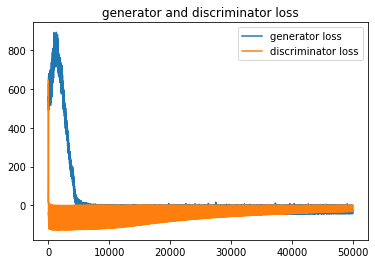

In [8]:
import os
import pandas as pd
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

random.seed(42)
class TrainGan:

    def __init__(self, num_historical_days, batch_size=128):
        self.batch_size = batch_size
        self.data = []

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
      
        for file in files:
            print(file)
            #Read in file -- note that parse_dates will be need later
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]

            #Normilize using a of size num_historical_days
            df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days)
            -df.rolling(num_historical_days).min().shift(-num_historical_days)))

            #Drop days that we don't have data for
            df = df.dropna()
            
            #Hold out 500 days for testing
            df = df[500:]

            for i in range(num_historical_days, len(df), num_historical_days):
                self.data.append(df.values[i-num_historical_days:i])

        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200)

    def random_batch(self, batch_size=128):
        batch = []
        while True:
            batch.append(random.choice(self.data))
            if (len(batch) == batch_size):
                yield batch
                batch = []

    def train(self, print_steps=100, display_data=100, save_steps=SAVE_STEPS_AMOUNT):
        if not os.path.exists(f'{googlepath}models'):
            os.makedirs(f'{googlepath}models')
        sess = tf.Session()
        
        G_loss = 0
        D_loss = 0
        G_l2_loss = 0
        D_l2_loss = 0
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        currentStep = "0"
        
        g_loss_array = []
        d_loss_array = []
        
        if os.path.exists(f'{googlepath}models/checkpoint'):
                with open(f'{googlepath}models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, X in enumerate(self.random_batch(self.batch_size)):

            
            
            
            if i % 1 == 0:
                _, D_loss_curr, D_l2_loss_curr = sess.run([self.gan.D_solver, self.gan.D_loss, self.gan.D_l2_loss], feed_dict=
                        {self.gan.X:X, self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                D_loss += D_loss_curr
                D_l2_loss += D_l2_loss_curr
            if i % 1 == 0:
                _, G_loss_curr, G_l2_loss_curr = sess.run([self.gan.G_solver, self.gan.G_loss, self.gan.G_l2_loss],
                        feed_dict={self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                G_loss += G_loss_curr
                G_l2_loss += G_l2_loss_curr
                
            g_loss_array.append(G_loss_curr - G_l2_loss)
            d_loss_array.append(D_loss_curr - D_l2_loss)
            
            
            if (i+1) % print_steps == 0:
                print('Step={} D_loss={}, G_loss={}'.format(i + int(currentStep), D_loss/print_steps - D_l2_loss/print_steps, G_loss/print_steps - G_l2_loss/print_steps))
                G_loss = 0
                D_loss = 0
                G_l2_loss = 0
                D_l2_loss = 0
            if (i+1) % save_steps == 0:
                saver.save(sess, f'{googlepath}/models/gan.ckpt', i + int(currentStep))
            
            # end training at training_amount epochs
            if ((i + int(currentStep)) > TRAINING_AMOUNT):
                
                print("Reached {} epochs for GAN".format(i + int(currentStep)))
                sess.close()
                
                axisX = np.arange(0,len(g_loss_array),1)
                plt.plot(axisX, g_loss_array, label='generator loss')
                plt.plot(axisX, d_loss_array, label='discriminator loss')
                plt.legend()
                plt.title('generator and discriminator loss')
                plt.show()
                
                break

            # if (i+1) % display_data == 0:
            #     print('Generated Data')
            #     print(sess.run(self.gan.gen_data, feed_dict={self.gan.Z:self.gan.sample_Z(1, 200)}))
            #     print('Real Data')
            #     print(X[0])



tf.compat.v1.reset_default_graph()
gan = TrainGan(HISTORICAL_DAYS_AMOUNT, 128)
gan.train()



## **ADABOOST**

/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/MMM.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AOS.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ABT.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ABBV.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ACN.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ATVI.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AYI.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/ADBE.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AAP.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AMD.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AES.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AET.csv
/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AMG.

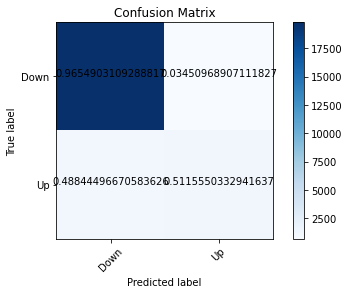

In [9]:
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import pandas as pd
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from sklearn.externals import joblib
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

class TrainAdaBoost:

    def __init__(self, num_historical_days, days=10, pct_change=0):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        
        assert os.path.exists(f'{googlepath}models/checkpoint')
        gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200, is_train=False)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            if os.path.exists(f'{googlepath}models/checkpoint'):
                    
                    with open(f'{googlepath}models/checkpoint', 'rb') as f:
                        model_name = next(f).split('"'.encode())[1]
                    model_name_string = model_name.decode()
                    model_name_string = model_name_string.replace("//", "/")
                    #filename = "{}models/{}".format(googlepath, model_name_string )
                    currentStep = model_name_string.split("-")[1]
                    new_saver = tf.train.import_meta_graph('{}.meta'.format(model_name_string))
                    new_saver.restore(sess, "{}".format(model_name_string))
            files = [os.path.join(f'{googlepath}stock_data', f) for f in os.listdir(f'{googlepath}/stock_data')]
            for file in files:
                print(file)
                #Read in file -- note that parse_dates will be need later
                df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
                df = df[['open','high','low','close','volume']]

                #Normilize using a of size num_historical_days
                labels = df.close.pct_change(days).map(lambda x: int(x > pct_change/100.0))
                df = ((df -
                df.rolling(num_historical_days).mean().shift(-num_historical_days))
                /(df.rolling(num_historical_days).max().shift(-num_historical_days)
                -df.rolling(num_historical_days).min().shift(-num_historical_days)))
                df['labels'] = labels

                df = df.dropna()

                #Hold out the testing data
                test_df = df[:500]
                df = df[500:]

                data = df[['open','high','low','close','volume']].values
                labels = df['labels'].values
                for i in range(num_historical_days, len(df), num_historical_days):
                    features = sess.run(gan.features, feed_dict={gan.X:[data[i-num_historical_days:i]]})
                    self.data.append(features[0])
#                     print(features[0])
                    self.labels.append(labels[i-1])
                data = test_df[['open','high','low','close','volume']].values
                labels = test_df['labels'].values
                for i in range(num_historical_days, len(test_df), 1):
                    features = sess.run(gan.features, feed_dict={gan.X:[data[i-num_historical_days:i]]})
                    self.test_data.append(features[0])
                    self.test_labels.append(labels[i-1])

    def train(self):
          params = {}
          params['objective'] = 'multi:softprob'
          params['eta'] = 0.01
          params['num_class'] = 2
          params['max_depth'] = 20
          params['subsample'] = 0.05
          params['colsample_bytree'] = 0.05
          params['eval_metric'] = 'mlogloss'
          clf = ada()
          train = self.data
          test = self.test_data
          
          clf.fit(train, self.labels)
          watchlist = [(train, 'train'), (test, 'test')]
          joblib.dump(clf, f'{googlepath}models/clf.pkl')
          cm = confusion_matrix(self.test_labels, clf.predict(test))
          print(cm)
          Accuracy = accuracy_score(self.test_labels, clf.predict(test))
          Precision = precision_score(self.test_labels, clf.predict(test))
          Sensitivity_recall = recall_score(self.test_labels, clf.predict(test))
          Specificity = recall_score(self.test_labels, clf.predict(test), pos_label=0)
          F1_score = f1_score(self.test_labels, clf.predict(test))
          print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
          plot_confusion_matrix(cm, ['Down', 'Up'], normalize=True, title="Confusion Matrix")

tf.compat.v1.reset_default_graph()
boost_model = TrainAdaBoost(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
boost_model.train() 


## **Single Company stock price prediction** Here we use Apple as a single company. Now we predict the stock of apple company

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
url = '/content/drive/MyDrive/Sanjay Project /Code/28January2023/stock_data/AAPL.csv'
df = pd.read_csv(url)
df

,timestamp,open,high,low,close,volume
0,2023-01-27,143.155,147.230,143.08,145.93,70555843
1,2023-01-26,143.170,144.250,141.90,143.96,54105068
2,2023-01-25,140.890,142.430,138.81,141.86,65799349
3,2023-01-24,140.305,143.160,140.30,142.53,66435142
4,2023-01-23,138.120,143.315,137.90,141.11,81760313
...,...,...,...,...,...,...
5843,1999-11-05,84.620,88.370,84.00,88.31,3721500
5844,1999-11-04,82.060,85.370,80.62,83.62,3384700
5845,1999-11-03,81.620,83.250,81.00,81.50,2932700
5846,1999-11-02,78.000,81.690,77.31,80.25,3564600


In [86]:
df_train = df.iloc[:1000,1:2].values
df_valid = df.iloc[1000:1100, 1:2].values
df_test = df.iloc[1100:,1:2].values

In [87]:
#Fearure scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
df_train_scaled = sc.fit_transform(df_train)
df_valid_scaled = sc.transform(df_valid)

In [88]:
#creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
for i in range(60, df_train_scaled.shape[0]):
    X_train.append(df_train_scaled[i-60:i, 0])
    y_train.append(df_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

for i in range(60, df_valid_scaled.shape[0]):
    X_valid.append(df_train_scaled[i-60:i, 0])
    y_valid.append(df_train_scaled[i, 0])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [89]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import callbacks

In [90]:
#RNN
regressor = Sequential()

early_stopping = callbacks.EarlyStopping(
    min_delta=0, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [91]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [97]:
regressor.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
             epochs = 500,
             batch_size = 32,
              callbacks=[early_stopping],
              verbose = 0
             )

In [98]:
#Getting the predicted stock price
df_total = df['open']
inputs = df_total[len(df_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
preds= regressor.predict(X_test)
preds = sc.inverse_transform(preds)

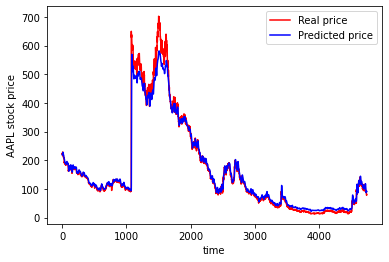

In [99]:
plt.plot(df_test, color = 'red', label = 'Real price')
plt.plot(preds, color = 'blue', label = 'Predicted price')
plt.ylabel('AAPL stock price')
plt.xlabel('time')
plt.legend()
plt.show()